# Software Setup, Dependencies

In [1]:
%pip install -r requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib
from scipy.optimize import curve_fit


import salduba.simulation.ggk as ggk
importlib.reload(ggk)
from salduba.simulation.ggk import exponential, parametrized_gamma


# Set up Configuration parameters

In [3]:
inter_arrival_time = 1.0
op_time = inter_arrival_time/1000
target_utilization = 0.9
k_servers: int = 10
processing_time = inter_arrival_time * k_servers * target_utilization
gamma_shape = 9.0

n_jobs: int = 50000
sampling_target: float = 5.0
simulation_factor: float = 100.0

sampling_period = int(inter_arrival_time * sampling_target)
time_limit = int(inter_arrival_time * n_jobs + target_utilization/(1-target_utilization)*inter_arrival_time*simulation_factor)
jobs_limit: int = round(time_limit/inter_arrival_time)

time_unit: float = sampling_period*10

arrival_distribution: ggk.Distribution = exponential(inter_arrival_time, time_unit)
processing_distribution: ggk.Distribution = parametrized_gamma(gamma_shape, processing_time, time_unit)
success_distribution = ggk.coin_toss(0.95)

# Metrics Calculation Parameters

n_metrics_intervals = 200
warm_up_fraction = 0.1

# Simulation Values

## Arrival Times & Jobs Data Frame

*jobs := [arrival time, processing time, start, complete, arrived, pending]*

- **Id** A unique Id for the job, corresponding to its arrival order
- **Arrival Time**: When the job arrives to the system
- **Processing Time**: The time the system takes to process the job once started
- **Start**: The time when the system starts processing the job.
- **Complete**: The time when the system completes processing of the job. It is always the case that $Complete = ArrivalTime + ProcessingTime$
- **Arrived**: How many jobs have arrived up until the time of this arrival, including this one.
- **Pending**: How many jobs are in the system or "pending" at the time of arrival.
- **WIP**: How many jobs are currently being actively worked on.
- **DONE**: How many jobs are currently Complete.

In [4]:
jobs: pd.DataFrame = ggk.initialize_jobs(n_jobs, arrival_distribution, processing_distribution, success_distribution)

jobs

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
0,0,0,13,580,-1,-1,1,1,-1,-1,-1,-1,-1,-1
1,1,13,40,286,-1,-1,1,2,-1,-1,-1,-1,-1,-1
2,2,53,25,339,-1,-1,1,3,-1,-1,-1,-1,-1,-1
3,3,78,12,196,-1,-1,1,4,-1,-1,-1,-1,-1,-1
4,4,90,110,301,-1,-1,1,5,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2480324,64,492,-1,-1,1,49997,-1,-1,-1,-1,-1,-1
49997,49997,2480388,128,314,-1,-1,1,49998,-1,-1,-1,-1,-1,-1
49998,49998,2480516,164,641,-1,-1,1,49999,-1,-1,-1,-1,-1,-1
49999,49999,2480680,4,411,-1,-1,1,50000,-1,-1,-1,-1,-1,-1


In [5]:
history_starts, history_ends, samples = ggk.fill_in_dynamic_values(jobs, k_servers, warm_up_fraction)

(history_starts, history_ends)

In [7]:
samples

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
5001,5001,247615,77,334,248206,248540,1,5002,21,10,4980,1.769461,591,925
5002,5002,247692,11,372,248223,248595,1,5003,21,10,4981,1.427419,531,903
5003,5003,247703,32,338,248232,248570,1,5004,21,10,4982,1.565089,529,867
5004,5004,247735,36,651,248325,248976,1,5005,22,10,4982,0.906298,590,1241
5005,5005,247771,48,400,248339,248739,1,5006,20,10,4985,1.420000,568,968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2480324,64,492,2480325,2480817,1,49997,9,9,49987,0.002033,1,493
49997,49997,2480388,128,314,2480389,2480703,1,49998,8,8,49989,0.003185,1,315
49998,49998,2480516,164,641,2480517,2481158,1,49999,7,7,49991,0.001560,1,642
49999,49999,2480680,4,411,2480681,2481092,1,50000,6,6,49993,0.002433,1,412


# Exploration of Simulation

## WIP Avg stabilization

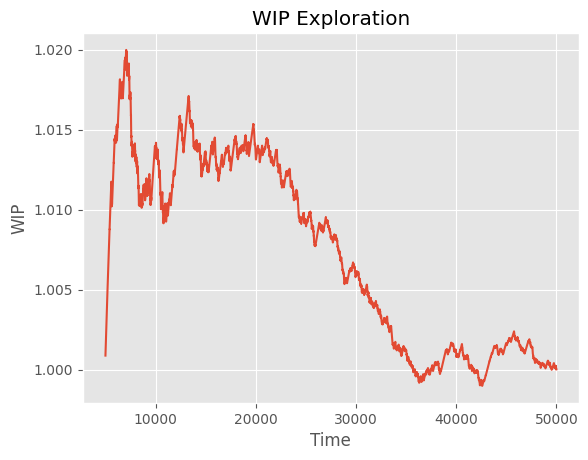

9.036319273614527

In [25]:
start_job = 5000
jobs_to_plot = 50000

mean_wip = jobs['WIP'].mean()
ratio = [jobs['WIP'][0:idx].mean()/mean_wip for idx in range(start_job, jobs_to_plot)]

plt.figure()
plt.plot(job_idx, ratio)
plt.xlabel('Time')
plt.ylabel('WIP')
plt.title('WIP Exploration')
plt.show()

mean_wip

# Metrics Parameters

## Determine valid samples from the simulation

- Allow to warm up
- Eliminate arrivals that don't complete

In [9]:
total_duration = history_ends - history_starts
metric_interval = round((history_ends - history_starts)/n_metrics_intervals)
ticks = np.arange(history_starts, history_ends, metric_interval)

In [10]:
samples

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
5001,5001,247615,77,334,248206,248540,1,5002,21,10,4980,1.769461,591,925
5002,5002,247692,11,372,248223,248595,1,5003,21,10,4981,1.427419,531,903
5003,5003,247703,32,338,248232,248570,1,5004,21,10,4982,1.565089,529,867
5004,5004,247735,36,651,248325,248976,1,5005,22,10,4982,0.906298,590,1241
5005,5005,247771,48,400,248339,248739,1,5006,20,10,4985,1.420000,568,968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2480324,64,492,2480325,2480817,1,49997,9,9,49987,0.002033,1,493
49997,49997,2480388,128,314,2480389,2480703,1,49998,8,8,49989,0.003185,1,315
49998,49998,2480516,164,641,2480517,2481158,1,49999,7,7,49991,0.001560,1,642
49999,49999,2480680,4,411,2480681,2481092,1,50000,6,6,49993,0.002433,1,412


In [11]:
samples['QueuingFactor'].min()

0.000725689404934688

In [12]:
# Make the calculation period a bit longer than the metric period, just for testing (Trailing average longer than metric period)
calculation_period = round(metric_interval*1.2)
  
calculation_intervals = [pd.Interval(tick-calculation_period, tick, closed='left') for tick in ticks]
calculation_groups = [[itv.left, itv.right, samples[samples['Complete'].between(itv.left, itv.right, inclusive='left')]] for itv in calculation_intervals]

metrics = pd.DataFrame(
  columns=['Yield', 'Throughput', 'ProcessingTime', 'Utilization', 'WaitTime', 'LeadTime', 'WIP', 'QueuingFactor'],
  index=[g[1] for g in calculation_groups],
  data=[
    (
     g[2]['Success'].mean() if len(g[2]) > 0 else 0,
     g[2].index.size/calculation_period,
     g[2]['ProcessingTime'].mean() if g[2].index.size > 0 else 0,
     -1,
     g[2]['WaitTime'].mean() if g[2].index.size > 0 else 0,
     g[2]['LeadTime'].mean() if g[2].index.size > 0 else 0,
     (g[2]['InterArrival']*g[2]['WIP']).sum()/g[2]['InterArrival'].sum() if g[2].index.size > 0 else 0,
     g[2]['QueuingFactor'].mean() if g[2].index.size > 0 else 0
   ) for g in calculation_groups]
  )[1:]
metrics['Utilization'] = metrics['Throughput']*metrics['ProcessingTime']/k_servers
metrics

,Yield,Throughput,ProcessingTime,Utilization,WaitTime,LeadTime,WIP,QueuingFactor
258784,0.962963,0.016116,466.611111,0.751981,640.541667,1107.152778,9.987971,1.534383
269953,0.960993,0.021040,474.053191,0.997411,970.372340,1444.425532,9.978098,2.302648
281122,0.966418,0.019996,470.813433,0.941416,472.503731,943.317164,9.458287,1.100244
292291,0.931741,0.021861,449.170648,0.981922,217.460751,666.631399,9.920018,0.566724
303460,0.950877,0.021264,444.214035,0.944572,111.550877,555.764912,9.438016,0.302328
...,...,...,...,...,...,...,...,...
2425570,0.937500,0.020294,433.352941,0.879445,50.555147,483.908088,8.732134,0.135258
2436739,0.931900,0.020816,454.211470,0.945497,326.688172,780.899642,9.509291,0.811487
2447908,0.944030,0.019996,451.466418,0.902731,109.880597,561.347015,9.206108,0.271527
2459077,0.950570,0.019622,443.585551,0.870425,52.730038,496.315589,8.574454,0.133804


## Reporting Periods

Will prepare two *Reports* with each 1/2 of the samples.


In [13]:

mid_point = round((history_starts + history_ends)/2)

reporting_periods = [
  {
    'name': "Period 1",
    'start_time': history_starts,
    'end_time' : mid_point,
    'jobs': samples[samples['Complete'] <= mid_point],
    'metrics': metrics.loc[history_starts:mid_point]
  },
  {
    'name': "Period 2",
    'start_time': mid_point+1,
    'end_time': history_ends,
    'jobs': samples[samples['Complete'] > mid_point],
    'metrics': metrics.loc[mid_point:]
  }
]



# Yields

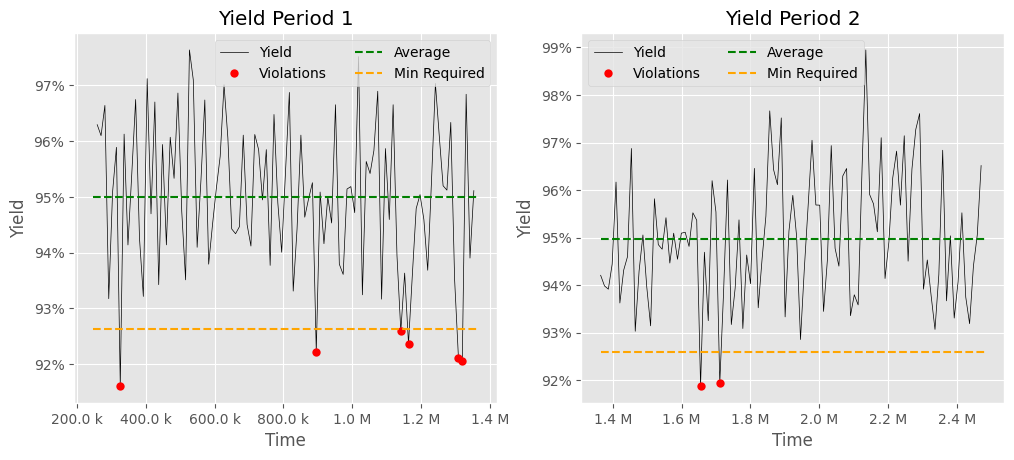

In [26]:
plt.style.use('ggplot')

yield_min_factor = 0.975

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
ax0, ax1 = axes.ravel()

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  yield_avg = metrics['Yield'].mean()
  min_required = yield_avg*yield_min_factor
  metrics['Yield'].plot(ax=ax, color='black', linestyle='-', linewidth=0.5)
  metrics[metrics['Yield'] < min_required]['Yield'].plot(ax=ax, color='black', linestyle='', marker='o', markeredgewidth=0.0, markerfacecolor='red', label='Violations')
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.PercentFormatter(xmax=1.0, decimals=0))
  ax.plot([r['period']['start_time'], r['period']['end_time']], [yield_avg, yield_avg], label="Average", color="green", linestyle='--')
  ax.plot([r['period']['start_time'], r['period']['end_time']], [min_required, min_required], label="Min Required", color='orange', linestyle='--')
  ax.set_xlabel('Time')
  ax.set_ylabel('Yield')
  ax.set_title(f"Yield {r['period']['name']}")
  ax.legend(ncols=2)
  

plt.show()



# Throughput

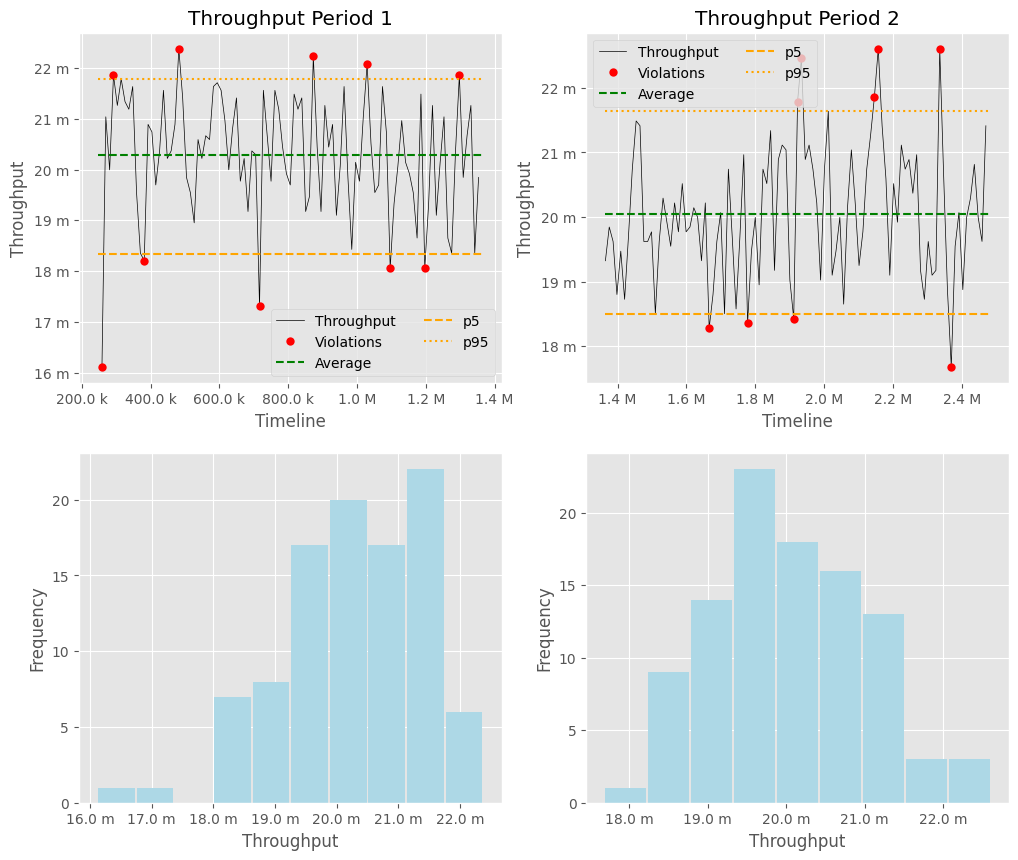

In [27]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'Throughput'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, False)

# Utilization

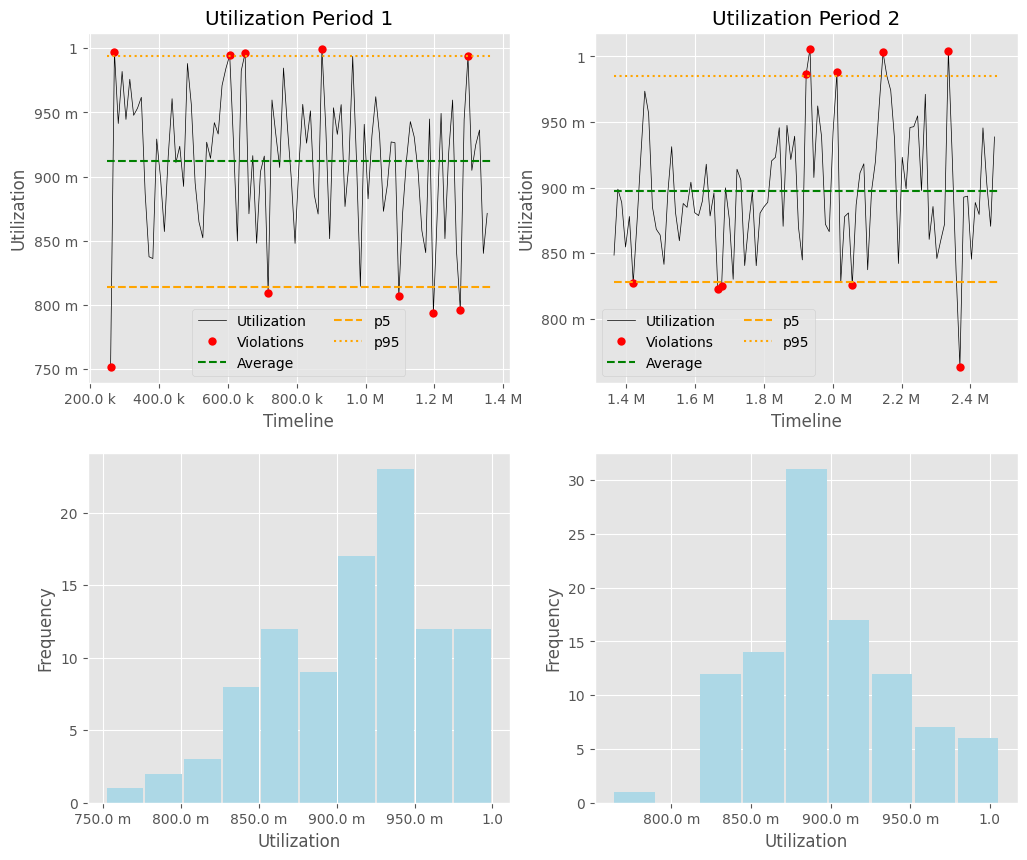

In [28]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'Utilization'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, False)

# Dwell Times

## Wait Time

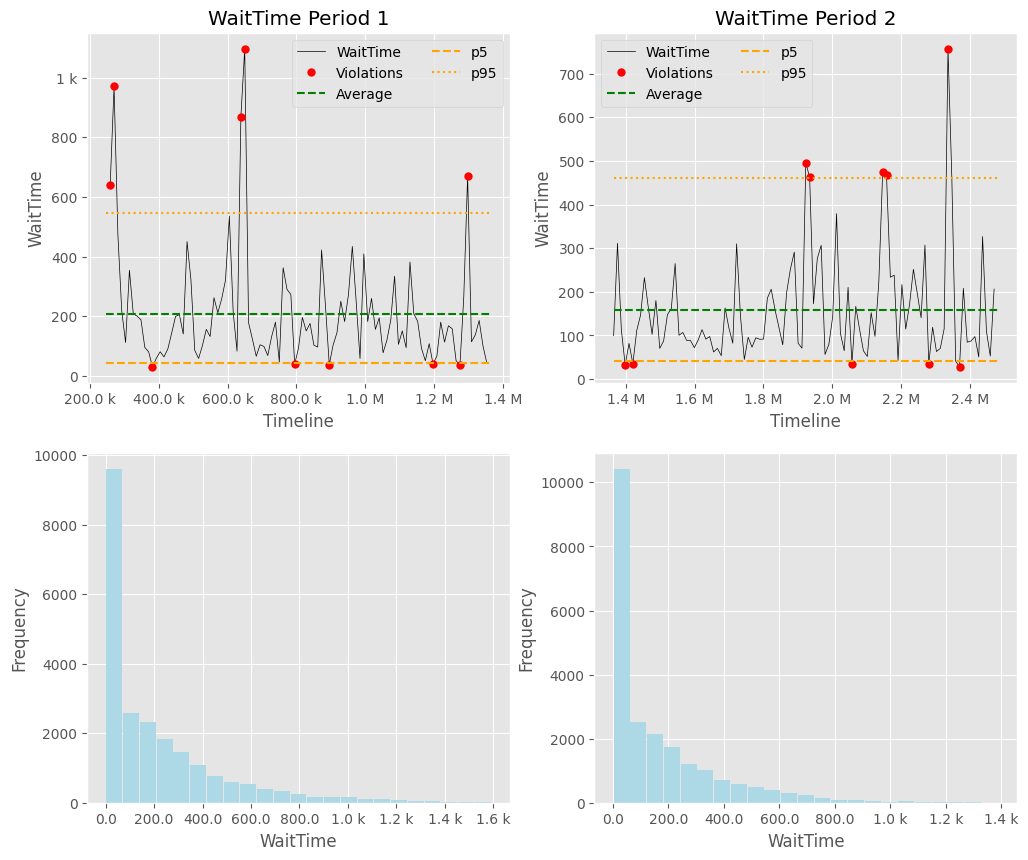

In [30]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'WaitTime'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)

## Processing Time

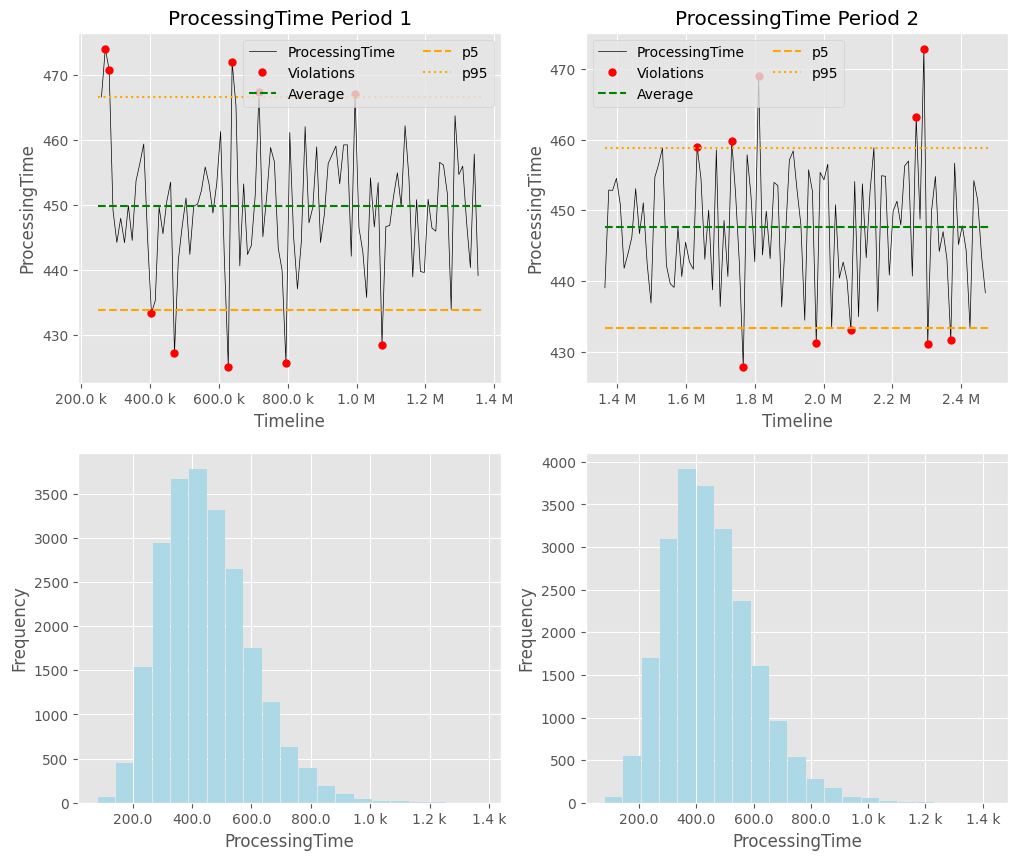

In [32]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'ProcessingTime'


ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)


## Lead Time

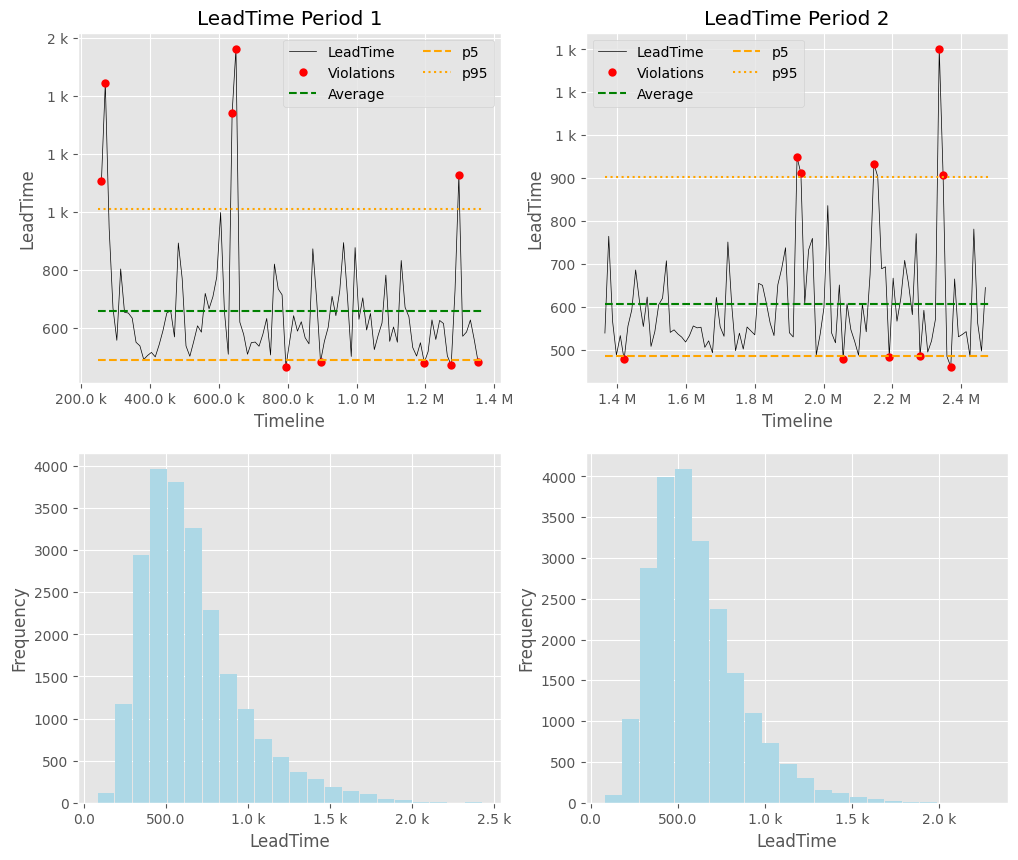

In [33]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'LeadTime'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)


## Queuing Factor

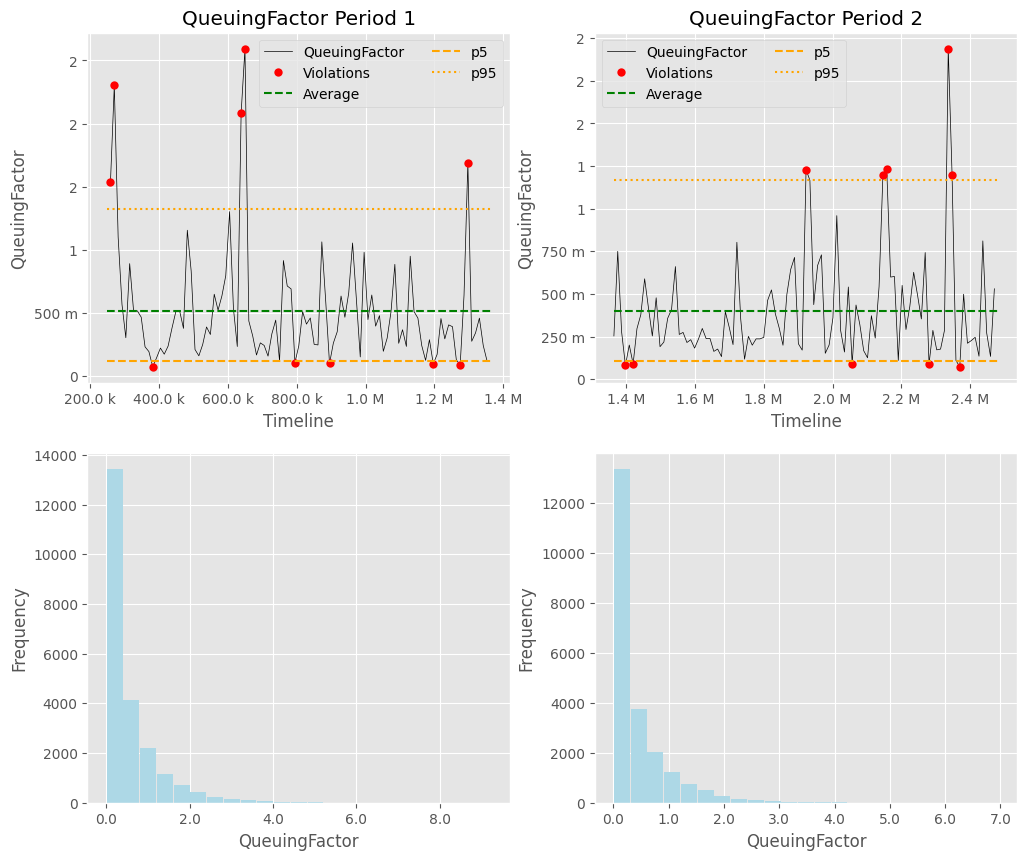

In [34]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'QueuingFactor'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)


# WIP

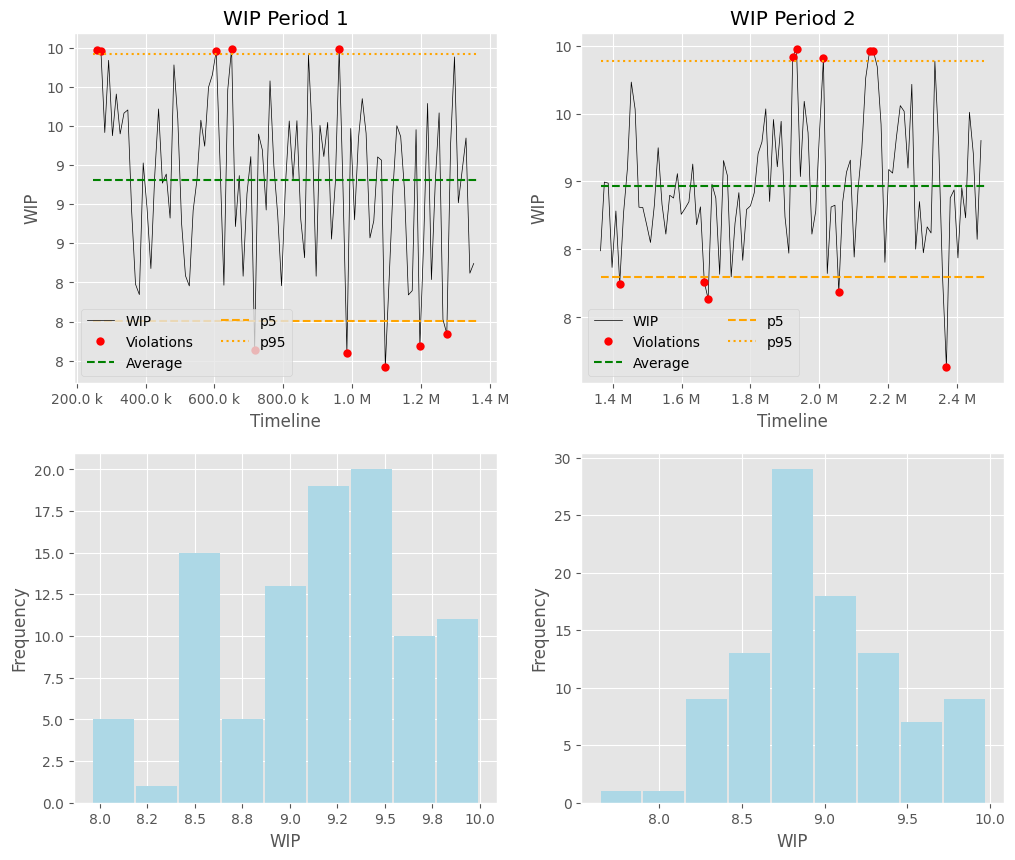

In [35]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'WIP'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, False)

# Cross Reports

## Lead Time vs. Throughput

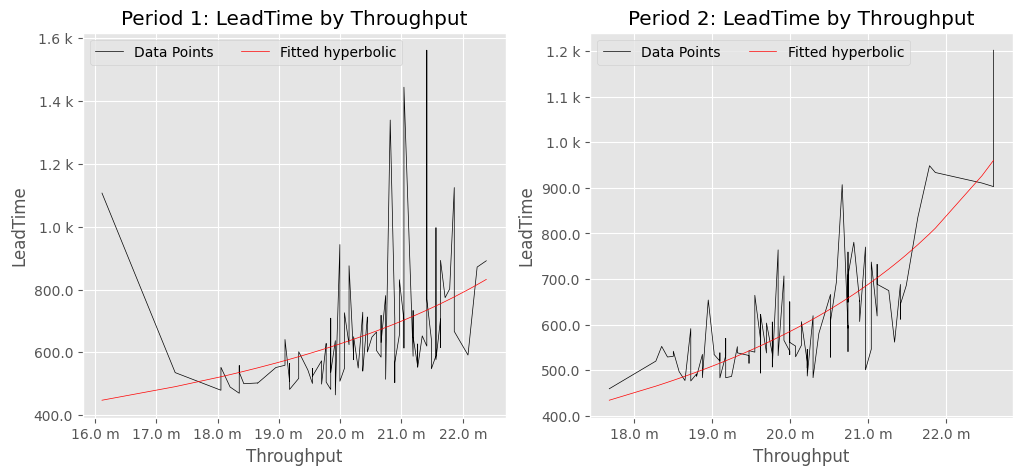

In [36]:
x_series = 'Throughput'
y_series = 'LeadTime'




fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

def target(th: float, tau: float, th_std: float, tau_std: float) -> float:
  c_s2 = np.power(tau_std/tau, 2.0)
  c_a2 = np.power(th_std*th, 2.0)
  var_squared = (c_s2+c_a2)/2.0
  rho = th*tau
  return var_squared/(1.0-rho)

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics.sort_values(x_series)
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5, label="Data Points")
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )
  fitted = ordered[x_series].apply(lambda x : target(x, param[0], param[1], param[2]))
  ax.plot(ordered[x_series], fitted, color='red', linestyle='-', linewidth=0.5, label="Fitted hyperbolic", )
  ax.legend(ncols=2)


## Lead Time vs. Utilization

Parameters: [1.28644338e+00 2.10754362e-06 4.38395249e-02]
Covariances: [[ 5.41607219e+14 -2.48308360e+10  1.84584873e+13]
 [-2.48308360e+10  1.74225511e+06 -8.46257691e+08]
 [ 1.84584873e+13 -8.46257691e+08  6.29082743e+11]]
Parameters: [5.89479582e+02 3.30605434e-04 1.21142670e+02]
Covariances: [[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


/var/folders/pc/2vy016913bs5kzpn254yq_f40000gn/T/ipykernel_30043/3533500624.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )


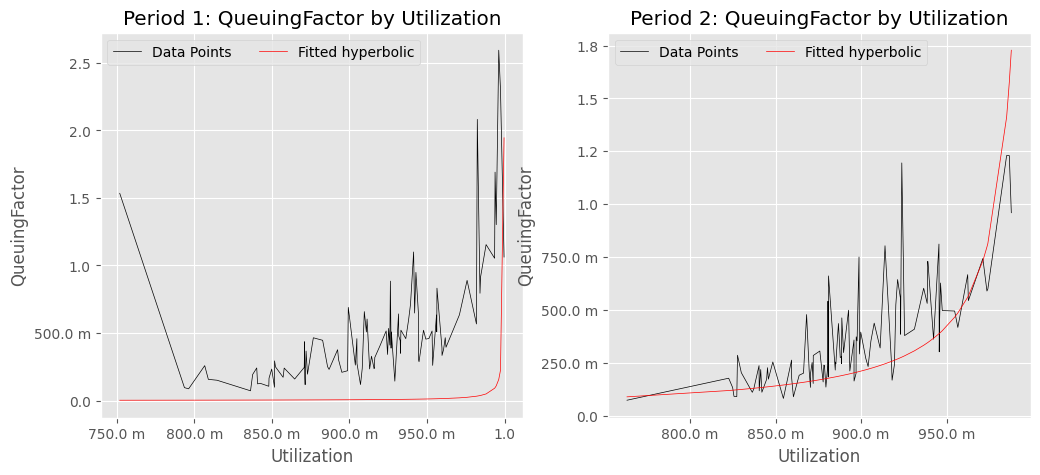

In [37]:
x_series = 'Utilization'
y_series = 'QueuingFactor'



fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

def target(rho: float, tau: float, th_std: float, tau_std: float) -> float:
  c_s2 = np.power(tau_std/tau, 2.0)
  c_a2 = np.power(rho*th_std/tau, 2.0)
  var_squared = (c_s2+c_a2)/2.0
  return var_squared/(1.0-rho)

variance_factor = 1.0

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics[metrics['Utilization'] < 1.0].sort_values(x_series)
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5, label="Data Points")
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )
  print(f"Parameters: {param}")
  print(f"Covariances: {param_cov}")
  fitted = ordered[x_series].apply(lambda x : target(x, param[0], param[1]*variance_factor, param[2]*variance_factor))
  ax.plot(ordered[x_series], fitted, color='red', linestyle='-', linewidth=0.5, label="Fitted hyperbolic", )
  ax.legend(ncols=2)
  


## Lead Time vs WIP

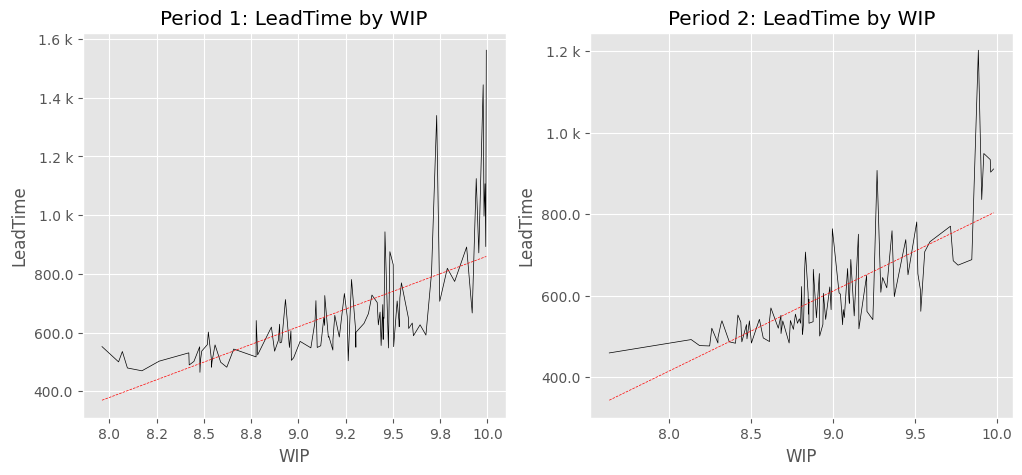

In [38]:
y_series = 'LeadTime'
x_series = 'WIP'

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics.sort_values(x_series)
  reg = Ridge().fit(ordered[[x_series]], ordered[[y_series]])
  trend = reg.predict(ordered[[x_series]])
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5)
  ax.plot(ordered[x_series], trend, color='red', linestyle='--', linewidth=0.5)